# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skojaku/applied-soft-comp/blob/master/notebooks/image-processing-01.ipynb)


## Image Processing

Let's perform the Fourier transform on an image.  
For an image $X$ with size $H \times W$, the Fourier transform of $X$ is:

$$
\begin{aligned}
\mathcal{F}(X)[h, w] &= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] \cdot e^{-2\pi i \frac{hk}{H}} \cdot e^{-2\pi i \frac{w\ell}{W}} \\
&= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] e^{-2\pi i \left(\frac{hk}{H} + \frac{w\ell}{W}\right)}
\end{aligned}
$$

The exponential term $e^{-2\pi i \left(\frac{hk}{H} + \frac{w\ell}{W}\right)}$ represents a 2D wave with frequency $(h, w)$, which looks like the following:


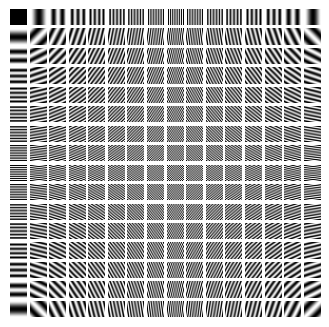

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def basis_function(img_size=256, u=0, v=0):
  '''
  img_size : square size of image f(x,y)
  u,v : spatial space indice
  '''
  N = img_size
  x = np.linspace(0, N-1, N)
  y = np.linspace(0, N-1, N)
  x_, y_ = np.meshgrid(x, y)
  bf = np.exp(-1j*2*np.pi*(u*x_/N+v*y_/N))
  if u == 0 and v == 0:
    bf = np.round(bf)
  real = np.real(bf) # The cosine part
  imag = np.imag(bf) # The sine part
  return real, imag

size = 16
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(size):
  for row in range(size):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
_, axs = plt.subplots(size, size, figsize=(4, 4))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')


**Note 🤔**: It is common to reorder the basis functions such that the lowest frequency components are at the center, which looks like this:


Text(0.5, 0.98, 'Real Part of Basis Functions')

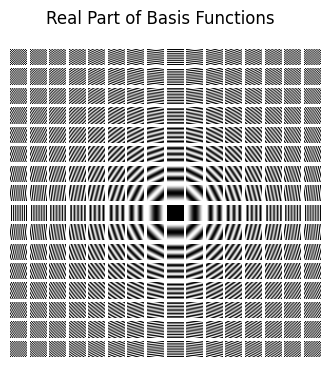

In [2]:
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(-size//2, size//2):
  for row in range(-size//2, size//2):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
fig, axs = plt.subplots(size, size, figsize=(4, 4))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.suptitle('Real Part of Basis Functions')



Now, let's perform the Fourier transform on an image.


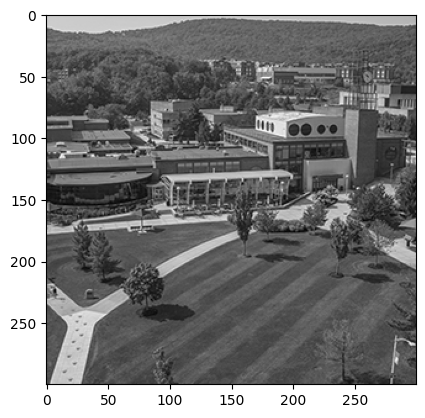

In [3]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Read image from URL
def read_jpeg_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Convert to RGB mode if needed (in case it's RGBA)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def image_to_numpy(img):
    return np.array(img)

def to_gray_scale(img_np):
    return np.mean(img_np, axis=2)

# URL of the image. You can change this to any image you want.
url = "https://www.binghamton.edu/news/images/uploads/features/20180815_peacequad02_jwc.jpg"

img = read_jpeg_from_url(url)
img_np = image_to_numpy(img)
img_gray = to_gray_scale(img_np)


# Trim
target_size = np.min([img_gray.shape[0], img_gray.shape[1]])
vcenter, hcenter = img_gray.shape[0]//2, img_gray.shape[1]//2
img_gray = img_gray[vcenter-target_size//2:vcenter+target_size//2, hcenter-target_size//2:hcenter+target_size//2]

plt.imshow(img_gray, cmap='gray')

Take the Fourier transform of the image.

In [4]:
ft_img_gray = np.fft.fft2(img_gray)

This decomposes the image into a sum of basis waves. Let's see the weights of the basis waves.

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

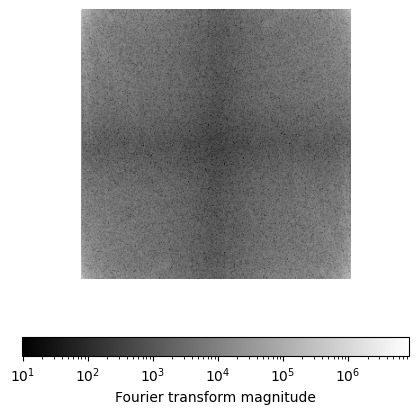

In [5]:
import matplotlib

weight = np.abs(ft_img_gray)

# real part
fig1, ax1 = plt.subplots(figsize=(5, 5))

ax1.imshow(weight, cmap='gray', norm=matplotlib.colors.LogNorm(), aspect='equal')
cbar = fig1.colorbar(ax1.images[0], ax=ax1, orientation='horizontal')
cbar.set_label('Fourier transform magnitude')
ax1.axis('off')

The brighter the pixel is, the more dominant the corresponding basis wave is in the image. We observed that there are some high frequency components, which correspond to the edges of the image.

Now, let's see the convolution of the image with a Prewitt operator.

In [6]:
K = np.array([[-1, -1, -1],
              [ 0,  0,  0],
              [ 1,  1,  1]])

This operator is used to detect the horizontal edges of the image.
Let's compute the Fourier transform of the Prewitt operator.

In [7]:
K_padd = np.zeros((img_gray.shape[0], img_gray.shape[1]))
K_padd[:K.shape[0], :K.shape[1]] = K

# convolution
FK = np.fft.fft2(K_padd)

**Note 🤔**: We have padded the operator to the same size as the image, which is required to perform the convolution. Now, let's see the weights of the basis waves.


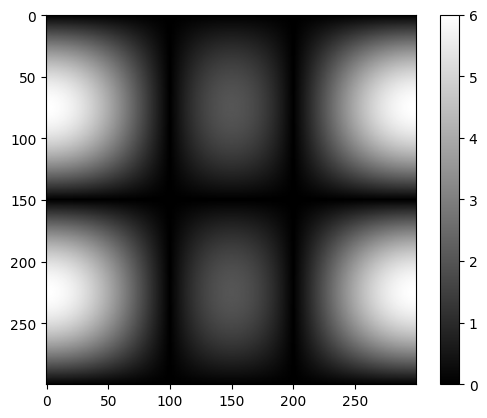

In [8]:
plt.imshow(np.abs(FK), cmap='gray')
cbar = plt.colorbar()

Observe that the low frequency components are suppressed, and the high frequency components are enhanced. This is because the Prewitt operator is a high-pass filter that only allows high-frequency components to pass through.


We now perform the convolution of the image with the Prewitt operator.

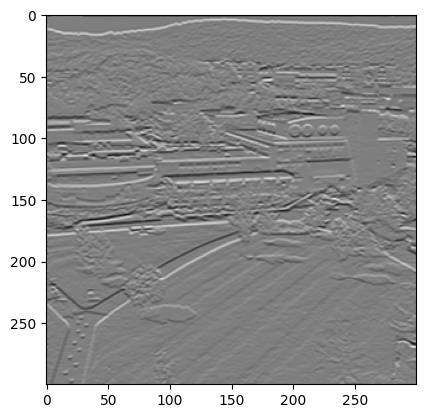

In [9]:
FX = np.fft.fft2(img_gray)
conv_img_gray = np.real(np.fft.ifft2(FX * FK))
plt.imshow(conv_img_gray, cmap='gray')

### Exercise 🏋️:

Design your own kernel to:
1. Detect the vertical edges of the image.
2. Smooth the image.


**1. Kernel to detect the vertical edges of the image.**

In [ ]:
K = np.array([[-1,  0,  1],
              [-1,  0,  1],
              [-1,  0,  1]])

**2. Kernel to smooth the image.**